<a href="https://colab.research.google.com/github/jmo2171/ml-climate/blob/main/src/wildfire_correlation_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports and setup

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load data


In [ ]:
data_orig = pd.read_csv("/content/drive/MyDrive/Spring 2025/ML and Climate/wildfire_project/ca_2000_mean_fire_earth_data.csv")

In [ ]:
print(data_orig.columns.tolist())
drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
data = data_orig.drop(columns=drop_cols)
drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']

data_class = data_orig.drop(columns=drop_cols)
data_class['FIRE_SIZE_CLASS'].unique()
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
data_class['FIRE_SIZE_CLASS_NUM'] = data_class['FIRE_SIZE_CLASS'].map(mapping)
data_class = data_class.drop(columns=['FIRE_SIZE_CLASS'])
df = data_class.dropna()
data_class


['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index']


,dead_fuel_1000,energy_release,humidity,max_temp_C,min_temp_C,precipitation,wind_speed,population_density,vegetation,drought_index,FIRE_SIZE_CLASS_NUM
0,21.963203,22.056320,0.002912,7.498254,-2.186072,0.0,6.620363,1.478607,2929.0,-0.3500,1
1,12.930136,47.595642,0.003536,15.886743,0.414148,0.0,3.208708,0.004660,3590.0,-2.2075,1
2,11.582568,55.798500,0.005862,26.379541,13.118188,0.0,2.040178,6.677308,4518.0,-2.7800,1
3,8.259057,76.284248,0.004474,20.343042,7.937524,0.0,2.230986,0.000000,2384.0,-2.6175,1
4,8.259057,76.284248,0.004474,20.343042,7.937524,0.0,2.230986,0.000000,2384.0,-2.6175,1
...,...,...,...,...,...,...,...,...,...,...,...
121323,8.107708,76.157257,0.006148,33.893488,16.492151,0.0,2.316175,40.920891,2216.0,-3.3700,1
121324,8.788897,64.763962,0.006864,26.668207,13.650201,0.0,1.466999,646.360901,2263.0,-2.6900,1
121325,10.918760,63.418705,0.006537,32.813928,13.751520,0.0,3.065458,646.360901,2653.0,-3.1725,1
121326,9.216611,67.622978,0.007353,32.346643,17.716425,0.0,3.537143,1565.474243,2068.0,-2.7975,2


In [ ]:
print(data_class.columns.tolist())


['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index', 'FIRE_SIZE_CLASS_NUM']


# neural network

In [ ]:


X = df[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
        'min_temp_C', 'precipitation', 'wind_speed',
        'population_density', 'vegetation', 'drought_index']].values
y = df['FIRE_SIZE_CLASS_NUM'].values - 1  # classes start at 1, shift to 0 for pytorch

# Scale the inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Neural network model
class FireSizeClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FireSizeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Setup
input_dim = X_train.shape[1]
num_classes = len(set(y))
model = FireSizeClassifier(input_dim, num_classes)

# Remember, y_train is your training labels
class_counts = np.bincount(y_train.numpy())  # add 1 if you shifted classes
print("Class counts:", class_counts)

# Or prettier
for cls, count in enumerate(class_counts, start=1):
    print(f"Class {cls}: {count} samples")

# Calculate class weights
total_samples = len(y_train)
class_weights = total_samples / (len(class_counts) * class_counts)

# Turn into tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Create weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights)


# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_preds = val_outputs.argmax(dim=1)
        val_accuracy = (val_preds == y_val).float().mean()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.4f}")


Class counts: [50657 39284  4636  1002   547   367   229]
Class 1: 50657 samples
Class 2: 39284 samples
Class 3: 4636 samples
Class 4: 1002 samples
Class 5: 547 samples
Class 6: 367 samples
Class 7: 229 samples
Epoch 10, Train Loss: 1.9346, Val Loss: 1.9310, Val Acc: 0.2700
Epoch 20, Train Loss: 1.9153, Val Loss: 1.9143, Val Acc: 0.2960
Epoch 30, Train Loss: 1.8944, Val Loss: 1.8962, Val Acc: 0.2961
Epoch 40, Train Loss: 1.8752, Val Loss: 1.8810, Val Acc: 0.2976
Epoch 50, Train Loss: 1.8601, Val Loss: 1.8716, Val Acc: 0.3006


In [ ]:
# Example new feature row
new_sample = df.sample(n=1)
print(new_sample)
X = new_sample[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
        'min_temp_C', 'precipitation', 'wind_speed',
        'population_density', 'vegetation', 'drought_index']].values
y = new_sample['FIRE_SIZE_CLASS_NUM'].values - 1  # classes start at 1, shift to 0 for pytorch


# Preprocess
new_sample_scaled = scaler.transform(X)
new_sample_tensor = torch.tensor(new_sample_scaled, dtype=torch.float32)

# Predict
model.eval()
with torch.no_grad():
    output = model(new_sample_tensor)
    print(output)
    predicted_class = output.argmax(dim=1).item()
    predicted_class += 1

print(f"Predicted FIRE_SIZE_CLASS_NUM: {predicted_class}")


       dead_fuel_1000  energy_release  humidity  max_temp_C  min_temp_C  \
76743       21.468485       25.000311  0.002642   14.790155    1.316888   

       precipitation  wind_speed  population_density  vegetation  \
76743            0.0    2.232959           65.183998      1639.0   

       drought_index  FIRE_SIZE_CLASS_NUM  
76743         3.4225                    1  
tensor([[ 1.6687,  1.4265,  0.6201,  0.0858, -0.2135, -0.4877, -0.9793]])
Predicted FIRE_SIZE_CLASS_NUM: 1


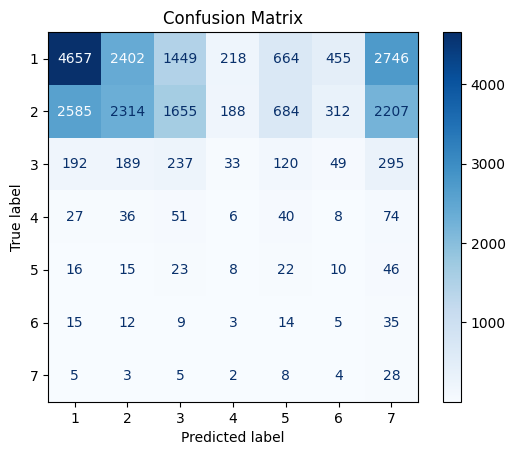

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_preds = val_outputs.argmax(dim=1)

# Shift classes back if necessary
val_preds_shifted = val_preds + 1
y_val_shifted = y_val + 1

# Confusion matrix
cm = confusion_matrix(y_val_shifted.cpu(), val_preds_shifted.cpu())

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6,7])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# svm

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset

# Features and target
X = df[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
        'min_temp_C', 'precipitation', 'wind_speed',
        'population_density', 'vegetation', 'drought_index']]
y = df['FIRE_SIZE_CLASS_NUM']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [ ]:
from sklearn.svm import SVC

# Automatically balance classes
svm = SVC(class_weight='balanced', probability=True)

# Train
svm.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Predict
y_pred = svm.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
disp.plot(cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")
